# Project: Automatic classification of skin lesions (melanoma detection)

# TB 3:  Image and Pattern recognition UP3
                             

##                                                         NAJLAA SRIFI

## 1.Introduction

In this project, the objective is to propose several methods to classify skin lesions.

Such a project would be very useful not only for dermatologists, who will make more accurate diagnoses and therefore make better decisions, but also for general practitioners, who would refer patients to the specialist in a more appropriate way.

Automatic melanoma detection - based on the analysis of dermoscopy images - has been receiving an increasing attention in the literature. Most works reproduce the classic rules used by dermatologists, extracting features linked to them. However, the extraction of such kind of features needs a previous segmentation of the lesion, which is often considered a very tricky step, as it may not be clear, even for specialists, where the boundaries of the lesion are. Other methods have been investigated in the literature where dermoscopic images do not need any segmentation process. Such a method uses a texture descriptor computed with the Local Binary Patterns (LBPs). Nethertheless, only intensity information of the color components are taken into consideration

We start by importing all the libraries we will need in this project

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
import cv2
from skimage.measure import label, regionprops
import pandas as pd
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from keras.layers import  BatchNormalization
from keras.constraints import maxnorm
from tensorflow.keras.layers import  LSTM
from skimage import color
import warnings
warnings.filterwarnings("ignore")

## 2. Database 

First, we import the database that contains the information about the images.  The goal of this project is to classify the original images of pigmented skin lesions acquired by dermoscopy into two classes: the first class contains melanomas and the second contains the remaining benign lesions.

In [2]:
data = pd.read_csv("ISIC-2017_Data_GroundTruth_Classification.csv", delimiter = ",")
data

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
1995,ISIC_0015220,0.0,1.0
1996,ISIC_0015233,0.0,1.0
1997,ISIC_0015260,0.0,1.0
1998,ISIC_0015284,1.0,0.0


Then we import the different images of our database, while classifying them according to three classes: 

- Orginal image

- Segmented lesion

- superpixels image

In [3]:
directory = "./PROJECT_Data"
files = sorted(os.listdir(directory))[0:]
originalImages = [] #Original Image
segmentatedLesion = [] # segmented Image
superpixels = []  # Superpixel Image
for file in files:
    ide = file[:12]
    if file == (ide + ".jpg"):
        originalImages.append(cv2.imread(directory + "/" + file))
        cv2.imwrite('./Original Images'+ "/" + file, cv2.imread(directory + "/" + file))
    elif file == (ide + "_segmentation.png"):
        segmentatedLesion.append(cv2.imread(directory + "/" + file, cv2.IMREAD_GRAYSCALE))
    else:
        superpixels.append(cv2.imread(directory + "/" + file, cv2.COLOR_BGR2RGB))
                               

Text(0.5, 1.0, 'Superpixels Image')

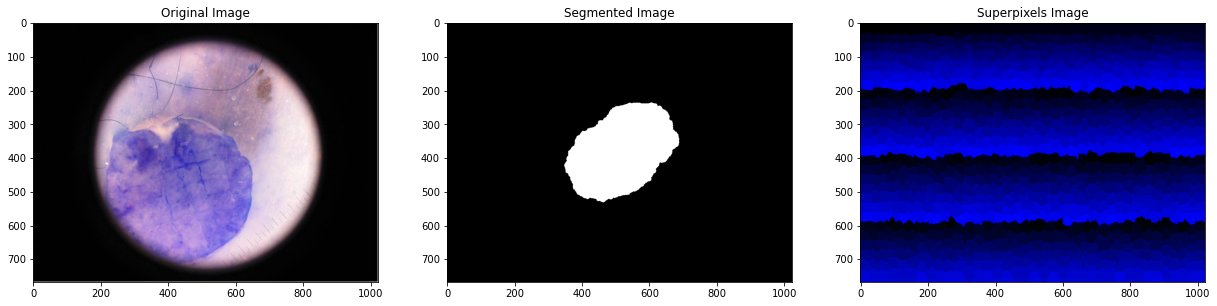

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21, 5))
ax1.imshow(originalImages[4])
ax1.set_title("Original Image")
ax2.imshow(segmentatedLesion[6], cmap = "gray")
ax2.set_title("Segmented Image")
ax3.imshow(superpixels[8])
ax3.set_title("Superpixels Image")

we check that we have 200 original images, 200 superpixels and 200 segmented lesion

In [5]:
print(len(originalImages))
print(len(segmentatedLesion))
print(len(superpixels))

200
200
200


## 3. Features extraction

In this part, the objective is to extract the morphological and geometrical features of each image in the database.  We will also extract the intensity and texture descriptors

### 3.1 Geometrical and morphological descriptors using the binary segmented image 

We describe the segmented binary images of our database, using morphological and geometrical descriptors. To do this we will use the regionprops function which extracts the feature vector ShapeFeat as we do in the first project:

- **Area**: The number of pixels in the Image that specifies the convex hull, with all pixels within the hull filled in

- **Eccentricity**: Eccentricity of the ellipse that has the same second-moments as the region. The eccentricity is the ratio of the distance between the foci of the ellipse and its major axis length

- **Perimeter**: Distance around the boundary of the region. regionprops computes the perimeter by calculating the distance between each adjoining pair of pixels around the border of the region

- **EquivDiameter**: Diameter of a circle with the same area as the regio .Computed as $\sqrt(4\frac{Area}{\pi})$

- **Extent**: Ratio of pixels in the region to pixels in the total bounding box

- **FilledArea**: Number of pixels belonging to the region after filling its possible holes

- **MajorAxisLength**: Length (in pixels) of the major axis of the ellipse that has the same normalized second central moments as the region

- **MinorAxisLength**: 	Length (in pixels) of the minor axis of the ellipse that has the same normalized second central moments as the region

- **Solidity**: Proportion of the pixels in the convex hull that are also in the region

In [5]:
def get_shape_features(image_region):
    shape_features=[]
    label_image=label(image_region)
    props=regionprops(label_image)
    shape_features.append(props[0].area)
    shape_features.append(props[0].eccentricity)
    shape_features.append(props[0].perimeter)
    shape_features.append(props[0].equivalent_diameter)
    shape_features.append(props[0].extent)
    shape_features.append(props[0].filled_area)
    shape_features.append(props[0].minor_axis_length)
    shape_features.append(props[0].major_axis_length)
    shape_features.append(props[0].major_axis_length/props[0].minor_axis_length)
    shape_features.append(props[0].solidity)
    return(shape_features)

In [6]:
N = len(segmentatedLesion)
Morpho = np.zeros((N, 10))
for i in range(0, N):
    image = segmentatedLesion[i].astype("bool")
    shapeFeatVector = get_shape_features(image)
    Morpho[i,:] = shapeFeatVector 
Morpho = pd.DataFrame(Morpho, columns = ["Area", "Eccentricity", "Perimeter", "Equivalent Diameter", 
                                             "Extent", "Filled area", "Minor Axis Length", "Major Axis Length","Ratio","Solidity"])                                     
Morpho

,Area,Eccentricity,Perimeter,Equivalent Diameter,Extent,Filled area,Minor Axis Length,Major Axis Length,Ratio,Solidity
0,364956.0,0.757181,2586.885569,681.671777,0.731926,364956.0,556.405972,851.808557,1.530912,0.968834
1,53432.0,0.436456,1068.915872,260.828939,0.749923,53432.0,249.034859,276.789839,1.111450,0.927011
2,237402.0,0.597147,2421.010460,549.790519,0.642384,237402.0,496.327926,618.761026,1.246678,0.915687
3,260712.0,0.433660,2187.655121,576.150005,0.707612,260712.0,551.560706,612.112946,1.109783,0.955924
4,269484.0,0.666933,2014.410388,585.762482,0.757791,269484.0,508.604676,682.583151,1.342070,0.986359
...,...,...,...,...,...,...,...,...,...,...
195,369118.0,0.725531,3594.269478,685.547689,0.612461,369118.0,581.934162,845.601582,1.453088,0.866694
196,193598.0,0.554615,1788.285497,496.484269,0.743284,193598.0,457.358077,549.638309,1.201768,0.951758
197,273920.0,0.851266,2389.897762,590.563948,0.569705,273920.0,432.689420,824.587625,1.905726,0.920656
198,563610.0,0.699698,3338.042856,847.118964,0.770801,563610.0,752.907622,1053.844650,1.399700,0.901202


### 3.2 Texture descriptors using the original images 

**Local Binary Pattern** (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. Due to its discriminative power and computational simplicity, LBP texture operator has become a popular approach in various applications. It can be seen as a unifying approach to the traditionally divergent statistical and structural models of texture analysis. Perhaps the most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

The LBP feature vector, in its simplest form, is created in the following manner:

- For each pixel, compare the pixel to each of its 8 neighbors (on its left-top, left-middle, left-bottom, right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise.

- Where the center pixel’s value is greater than the neighbor’s value, write "1". Otherwise, write "0". This gives an 8-digit binary number (which is usually converted to decimal for convenience).

- Compute the histogram of the frequency of each "number" occurring (i.e., each combination of which pixels are smaller and which are greater than the center).

- Normalize the histogram.

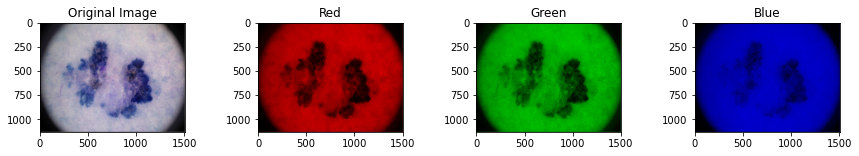

In [7]:
image = originalImages[30]
fig, ax = plt.subplots(nrows = 1, ncols=4,figsize=(15,2))
colors = ["Red", "Green", "Blue"]
ax[0].imshow(image)
ax[0].set_title("Original Image")

for c in range(3):    
    color_img = np.zeros(image.shape, dtype="uint8")  
    color_img[ :, :, c] = image[ :, :, c]
    ax[c+1].imshow(color_img)
    ax[c+1].set_title(colors[c])

The implementation of the **LBP** algorithm is done using the local_binary_pattern function already defined in the skimage.feature package. We then choose the following parameters: 

- **raduis**: Radius of circle (spatial resolution of the operator)

- **n_points**: Number of circularly symmetric neighbor set points (quantization of the angular space).

- **method** : we choose the uniform method which is finer quantization of the angular space which is gray scale and rotation invariant, and then the result includes only the patterns where all the black points are adjacent and all the white points are adjacent. 


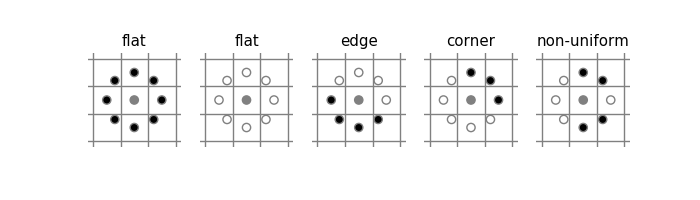

In [8]:
radius = 1 
n_points = 8 * radius
method = 'uniform'
num_features = 30
num_edges = len(originalImages)
LBP_data = np.zeros((num_edges, num_features))
for i, image in enumerate(originalImages):
    copy = np.copy(image)
    
    #Extracting the 3 components
    red_img = image[:, :, 0]
    green_img = image[:, :, 1]
    blue_img = image[:, :, 2]
    LBP = []
    for j, col in enumerate([red_img, green_img, blue_img]):
        lbp = local_binary_pattern(col, n_points, radius, method)
        x = itemfreq(lbp.ravel())
        hist = x[:, 1]/sum(x[:, 1])
        for h in hist:
            LBP.append(h)

    LBP_data[i, :] = LBP
LBP_data = pd.DataFrame(LBP_data, columns= ["Feature " + str(i) for i in range(30)])


In [9]:
LBP_data

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,0.009847,0.031693,0.021329,0.111112,0.128970,0.233938,0.075800,0.059684,0.270749,0.056878,...,0.012949,0.041120,0.021992,0.111586,0.111568,0.232300,0.082509,0.065086,0.249975,0.070916
1,0.005556,0.027952,0.009831,0.104661,0.072267,0.258789,0.067527,0.071716,0.332784,0.048917,...,0.005672,0.028336,0.009489,0.102296,0.069750,0.255046,0.066397,0.072787,0.340773,0.049454
2,0.010090,0.036489,0.025605,0.142860,0.183066,0.249698,0.097354,0.065865,0.125835,0.063138,...,0.014273,0.049164,0.026511,0.132095,0.147198,0.230557,0.104832,0.073255,0.139920,0.082194
3,0.008596,0.028755,0.017448,0.100512,0.109125,0.232035,0.063622,0.054111,0.334359,0.051438,...,0.009292,0.030396,0.017249,0.095487,0.099258,0.223527,0.063540,0.056782,0.349751,0.054717
4,0.007044,0.019979,0.016045,0.078819,0.135441,0.151102,0.046625,0.030337,0.470993,0.043615,...,0.008963,0.024115,0.017106,0.074498,0.120938,0.143425,0.049022,0.034338,0.476906,0.050689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.028088,0.056304,0.037676,0.124163,0.145718,0.183053,0.108362,0.078995,0.112300,0.125341,...,0.037638,0.069854,0.036519,0.102014,0.105965,0.152072,0.107566,0.091615,0.139051,0.157706
196,0.027081,0.059359,0.037742,0.118458,0.142328,0.186117,0.115039,0.073360,0.117065,0.123452,...,0.032743,0.069010,0.033418,0.100487,0.105847,0.167173,0.118269,0.081315,0.144691,0.147047
197,0.040648,0.062000,0.058479,0.120062,0.143537,0.137641,0.093310,0.072920,0.151686,0.119718,...,0.058883,0.083138,0.050269,0.084509,0.084415,0.096112,0.085419,0.092200,0.192842,0.172214
198,0.037160,0.067409,0.041372,0.109745,0.109762,0.166719,0.116424,0.084182,0.122538,0.144690,...,0.038176,0.069629,0.038444,0.103541,0.110365,0.162511,0.113323,0.085160,0.129208,0.149644


### 3.3 Intensity descriptors using the superpixel images

In this part we extract the intensity descriptors from the superpixel images. While looping over the images, and extracting the green and blue components, we then select the significant indices of the blue component and extract the superpixels, then remove the duplicate values, and finally reshape the vector.

In our case, the superpixel images are essentially blue images, so we will reduce the extraction to this component only.

In [10]:
#List of the number of superpixels
nb_pixel = []
for i in range(num_edges):
    image = superpixels[i]
    green_img = np.reshape(np.array(image[:,:,1]), (1,-1))
    green_img = green_img[0]

    blue_img = np.reshape(np.array(image[:,:,2]), (1,-1))
    blue_img = blue_img[0]
    indexes = [i for i in range(len(green_img)) if green_img[i] == 3]
    superpixels_layer = blue_img[indexes]
    trim_ = list(dict.fromkeys(superpixels_layer))
    nb_pixel += [max(trim_)]
nb_pixel = np.reshape(np.array(nb_pixel), (num_edges,1))
print(nb_pixel)

[[227]
 [214]
 [225]
 [222]
 [226]
 [229]
 [226]
 [212]
 [221]
 [221]
 [225]
 [228]
 [219]
 [219]
 [228]
 [214]
 [255]
 [255]
 [252]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [253]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [252]
 [221]
 [222]
 [227]
 [225]
 [225]
 [226]
 [255]
 [255]
 [255]
 [230]
 [227]
 [230]
 [228]
 [229]
 [225]
 [226]
 [230]
 [229]
 [228]
 [229]
 [228]
 [223]
 [224]
 [228]
 [229]
 [227]
 [228]
 [227]
 [227]
 [227]
 [227]
 [228]
 [228]
 [229]
 [228]
 [228]
 [228]
 [228]
 [230]
 [229]
 [229]
 [229]
 [229]
 [229]
 [230]
 [229]
 [228]
 [228]
 [227]
 [229]
 [227]
 [229]
 [230]
 [228]
 [230]
 [226]
 [230]
 [229]
 [225]
 [228]
 [226]
 [228]
 [224]
 [227]
 [230]
 [230]
 [227]
 [226]
 [229]
 [230]
 [226]
 [200]
 [255]
 [202]
 [250]
 [234]
 [241]
 [211]

### 3.4 selecting Features 

In the previous sections, we were able to obtain several features based on many types of images.   However, we could notice during this study that there is a big problem in relation to the time it takes to make the extraction this can be justified by firstly by the shape and the size of the images and then by the big number of the selected features.For this reason, we propose several methods that can select the important features like: 

- **Random Forest Classifier**
- **Pearson Correlation**
- **Principal Component Analysis (PCA)**
- **Feature Selection with a score function (ANOVA, Chi2, F_Score ...)**
- **XGBoost**


In the **PCA** method, the identity of the components is traced and the output is labeled as principal component number i, which will not be interesting in our case. 

The **random forest** and the **XGBoost** algorithms are good methods to extract essential features, the only problem is that they are not well known for large data sets. In our case, the database contains 200 images, which is indeed considered a small data set, but we have a very large number of features.

So we are left with Pearson correlation and feature selection with a score function. 


The **Pearson correlation coefficient** is a measure of the strength of a linear association between two variables and is denoted by r. Basically, a Pearson product-moment correlation attempts to draw a line of best fit through the data of two variables, and the Pearson correlation coefficient, r, indicates how far away all these data points are to this line of best fit (i.e., how well the data points fit this new model/line of best fit).The Pearson correlation coefficient, r, can take a range of values from +1 to -1. A value of 0 indicates that there is no association between the two variables. A value greater than 0 indicates a positive association; that is, as the value of one variable increases, so does the value of the other variable. A value less than 0 indicates a negative association. It is defined as :
$$ r=\frac{\sum_{i=1}^n (x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^n (x_{i}-\bar{x})^{2} \sum_{i=1}^n (y_{i}-\bar{y})^{2}}}$$
Where n is sample size, $x_{i},y_{i}$ are the individual sample points indexed with i and $\bar{x}$ is the mean of the values of the x-variable.

The scikit-learn library provides an implementation of most of the useful statistical measures.Such as:
- **Pearson’s Correlation Coefficient**: f_regression()
- **ANOVA**: f_classif() The F-test in one-way analysis of variance (ANOVA) is used to assess whether the expected values of a quantitative variable within several pre-defined groups differ from each other
- **Chi-Squared**: chi2() A chi-square (χ2) statistic is a test that measures how a model compares to actual observed data. The data used in calculating a chi-square statistic must be random, raw, mutually exclusive, drawn from independent variables, and drawn from a large enough sample.
- **Mutual Information**: mutual_info_classif() and mutual_info_regression()


In [11]:
Y = data["melanoma"][:200] 
Y.shape

(200,)

In [12]:
Morpho = SelectKBest(f_classif, k = 5).fit_transform(Morpho, Y)
Morpho = pd.DataFrame(Morpho, columns = ["Geometrical Feature " + str(i) for i in range(5)])
Morpho

,Geometrical Feature 0,Geometrical Feature 1,Geometrical Feature 2,Geometrical Feature 3,Geometrical Feature 4
0,364956.0,2586.885569,364956.0,851.808557,1.530912
1,53432.0,1068.915872,53432.0,276.789839,1.111450
2,237402.0,2421.010460,237402.0,618.761026,1.246678
3,260712.0,2187.655121,260712.0,612.112946,1.109783
4,269484.0,2014.410388,269484.0,682.583151,1.342070
...,...,...,...,...,...
195,369118.0,3594.269478,369118.0,845.601582,1.453088
196,193598.0,1788.285497,193598.0,549.638309,1.201768
197,273920.0,2389.897762,273920.0,824.587625,1.905726
198,563610.0,3338.042856,563610.0,1053.844650,1.399700


In [13]:
pearson_corr = pd.DataFrame()
pearson_corr["Column"] = LBP_data.columns
L = []
#Computing the Pearson Correlation
for column in LBP_data.columns:
    L.append(pearsonr(LBP_data[column], Y))

#Adding the p-value
pearson_corr["Absolute Pearson’s correlation"] = abs(np.array([element[0] for element in L]))
pearson_corr["p-value"] = [element[1] for element in L]
scores = pearson_corr.sort_values(by=['Absolute Pearson’s correlation'], ascending=False)[:20]

In [14]:
# the important features
LBP_new = pd.DataFrame()
for col in list(scores["Column"]):
    LBP_new["LBP " + col] = LBP_data[col]

LBP_new

,LBP Feature 14,LBP Feature 24,LBP Feature 4,LBP Feature 17,LBP Feature 7,LBP Feature 27,LBP Feature 23,LBP Feature 13,LBP Feature 19,LBP Feature 9,LBP Feature 3,LBP Feature 1,LBP Feature 21,LBP Feature 20,LBP Feature 29,LBP Feature 11,LBP Feature 10,LBP Feature 0,LBP Feature 15,LBP Feature 5
0,0.122627,0.111568,0.128970,0.064734,0.059684,0.065086,0.111586,0.113789,0.067386,0.056878,0.111112,0.031693,0.041120,0.012949,0.070916,0.037525,0.011510,0.009847,0.234297,0.233938
1,0.071431,0.069750,0.072267,0.072607,0.071716,0.072787,0.102296,0.102779,0.049431,0.048917,0.104661,0.027952,0.028336,0.005672,0.049454,0.027961,0.005672,0.005556,0.256527,0.258789
2,0.174721,0.147198,0.183066,0.069487,0.065865,0.073255,0.132095,0.139350,0.065373,0.063138,0.142860,0.036489,0.049164,0.014273,0.082194,0.040399,0.010605,0.010090,0.251075,0.249698
3,0.107045,0.099258,0.109125,0.055768,0.054111,0.056782,0.095487,0.096523,0.052414,0.051438,0.100512,0.028755,0.030396,0.009292,0.054717,0.029023,0.008402,0.008596,0.229597,0.232035
4,0.133092,0.120938,0.135441,0.031659,0.030337,0.034338,0.074498,0.077063,0.043816,0.043615,0.078819,0.019979,0.024115,0.008963,0.050689,0.020539,0.007059,0.007044,0.152593,0.151102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.149220,0.105965,0.145718,0.079223,0.078995,0.091615,0.102014,0.122702,0.124152,0.125341,0.124163,0.056304,0.069854,0.037638,0.157706,0.053814,0.027041,0.028088,0.189239,0.183053
196,0.125356,0.105847,0.142328,0.075767,0.073360,0.081315,0.100487,0.107814,0.131767,0.123452,0.118458,0.059359,0.069010,0.032743,0.147047,0.061900,0.027901,0.027081,0.186346,0.186117
197,0.111220,0.084415,0.143537,0.083160,0.072920,0.092200,0.084509,0.102143,0.146836,0.119718,0.120062,0.062000,0.083138,0.058883,0.172214,0.072839,0.048548,0.040648,0.116042,0.137641
198,0.116725,0.110365,0.109762,0.082808,0.084182,0.085160,0.103541,0.108140,0.141508,0.144690,0.109745,0.067409,0.069629,0.038176,0.149644,0.064670,0.035116,0.037160,0.173916,0.166719


## 4. Classification

In this part, we will classify our database based on the characteristics we extracted in the previous part. To do this, we will use several classification methods: 

- **Support Vector Machines**

- **Decision Tree**

- **Logistic Regression**

- **Random Forest**

- **K-nearest neighbors**

- **Recurrent Neural Networks**

- **Convolutional Neural Networks**

- **Long short-term memory**

The performance of each method is evaluated by calculating the confusion matrix, the accuracy, the F1_score and by drawing the ROC.

- **Confusion Matrix**:  This is a performance measure for a machine learning classification problem where the output can be two or more classes. It is a table with 4 different combinations of predicted and actual values:

     -- True Positive: You predicted positive and it’s true
     
     -- True Negative:You predicted negative and it’s true.
     
     -- False Positive: (Type 1 Error) You predicted positive and it’s false.
     
     -- False Negative: (Type 2 Error) You predicted negative and it’s false.
     

- **Accuracy**: The accuracy allows to know the proportion of good predictions compared to all predictions. The operation is simply : Number of good predictions / Total number of predictions


$$Accuracy=\frac{Tn+ Tp}{Tn+Tp+Fn+Fp}$$

- **F1-Score**: The F1-Score subtly combines precision and recall. It is interesting and more interesting than accuracy because the number of true negatives is not taken into account. And in situations of an unbalanced class as it is the case with Bradley Cooper, we have a majority of true negatives that completely distort our perception of the algorithm's performance. A large number of true negatives will leave the F1-Score untouched

$$F1-Score=2\frac{(Tp/(Tp+Fp))*(Tp/(Tp+Fn))}{Tp/(Tp+Fp)+Tp/(Tp+Fn)}$$

- **ROC curve**: The receiver operating characteristic (ROC), more commonly referred to as the "ROC curve", is a measure of the performance of a binary classifier, i.e., a system whose objective is to categorize items into two distinct groups based on one or more of the characteristics of each of these items. Graphically, the ROC measure is often represented in the form of a curve that gives the true positive rate as a function of the false positive rate 



In [15]:
variables = pd.concat([Morpho, 
                        LBP_new, 
                        pd.DataFrame(nb_pixel, columns = ["Superpixels"])], axis = 1)
index_with_nan = variables .index[variables .isnull().any(axis=1)]
variables .drop(index_with_nan,0, inplace=True)
variables 

,Geometrical Feature 0,Geometrical Feature 1,Geometrical Feature 2,Geometrical Feature 3,Geometrical Feature 4,LBP Feature 14,LBP Feature 24,LBP Feature 4,LBP Feature 17,LBP Feature 7,...,LBP Feature 1,LBP Feature 21,LBP Feature 20,LBP Feature 29,LBP Feature 11,LBP Feature 10,LBP Feature 0,LBP Feature 15,LBP Feature 5,Superpixels
0,364956.0,2586.885569,364956.0,851.808557,1.530912,0.122627,0.111568,0.128970,0.064734,0.059684,...,0.031693,0.041120,0.012949,0.070916,0.037525,0.011510,0.009847,0.234297,0.233938,227
1,53432.0,1068.915872,53432.0,276.789839,1.111450,0.071431,0.069750,0.072267,0.072607,0.071716,...,0.027952,0.028336,0.005672,0.049454,0.027961,0.005672,0.005556,0.256527,0.258789,214
2,237402.0,2421.010460,237402.0,618.761026,1.246678,0.174721,0.147198,0.183066,0.069487,0.065865,...,0.036489,0.049164,0.014273,0.082194,0.040399,0.010605,0.010090,0.251075,0.249698,225
3,260712.0,2187.655121,260712.0,612.112946,1.109783,0.107045,0.099258,0.109125,0.055768,0.054111,...,0.028755,0.030396,0.009292,0.054717,0.029023,0.008402,0.008596,0.229597,0.232035,222
4,269484.0,2014.410388,269484.0,682.583151,1.342070,0.133092,0.120938,0.135441,0.031659,0.030337,...,0.019979,0.024115,0.008963,0.050689,0.020539,0.007059,0.007044,0.152593,0.151102,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,369118.0,3594.269478,369118.0,845.601582,1.453088,0.149220,0.105965,0.145718,0.079223,0.078995,...,0.056304,0.069854,0.037638,0.157706,0.053814,0.027041,0.028088,0.189239,0.183053,246
196,193598.0,1788.285497,193598.0,549.638309,1.201768,0.125356,0.105847,0.142328,0.075767,0.073360,...,0.059359,0.069010,0.032743,0.147047,0.061900,0.027901,0.027081,0.186346,0.186117,242
197,273920.0,2389.897762,273920.0,824.587625,1.905726,0.111220,0.084415,0.143537,0.083160,0.072920,...,0.062000,0.083138,0.058883,0.172214,0.072839,0.048548,0.040648,0.116042,0.137641,247
198,563610.0,3338.042856,563610.0,1053.844650,1.399700,0.116725,0.110365,0.109762,0.082808,0.084182,...,0.067409,0.069629,0.038176,0.149644,0.064670,0.035116,0.037160,0.173916,0.166719,248


After gathering all the features in a single database **variables**, and before dividing this database into training and testing, we normalize it to avoid that the Machine Learning algorithms take more time to find the optimal predictive model. Indeed, finding an optimal predictive model is often like minimizing a cost function using Gradient Descent.  During the iterations of the Gradient Descent to compute the best weights($\theta$), if the data are not normalized some weights will update faster than others. This depends on the order of magnitude of the different features. This difference in "speed" of updating the $\theta$, will lead to Gradient Descent taking longer to converge and therefore find the optimal model.



In [16]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(variables)
X = pd.DataFrame(X, columns = variables.columns)
print("Data normalized.")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print("Data split.")
print("Train predictor shape: ", X_train.shape)
print("Test predictor shape: ", X_test.shape)


Data normalized.
Data split.
Train predictor shape:  (140, 26)
Test predictor shape:  (60, 26)


### 4.1  Support Vector Machines (SVM)

**SVMs** are a family of machine learning algorithms that can be used to solve classification, regression and anomaly detection problems. They are known for their strong theoretical guarantees, their great flexibility as well as their simplicity of use even without much knowledge of data mining. The principle of SVM is simple: their goal is to separate the data into classes using a boundary that is as "simple" as possible, so that the distance between the different groups of data and the boundary that separates them is maximal. This distance is also called "margin". This notion of border assumes that the data are linearly separable, which is rarely the case. To overcome this, SVMs often rely on the use of "kernels". These mathematical functions allow to separate the data by projecting them into a feature space (a vector space of higher dimension). The technique of margin maximization allows us to guarantee a better robustness to noise and therefore a more generalizable model. 

In sklearn, the function of SVM use different kernels such as: 
- **linear** 
- **polynomial**
- **rbf**
- **sigmoid**

Each kernel has its own characteristics and properties. To choose the best one for our case, we will test them all and take the one that gives the best performance. 

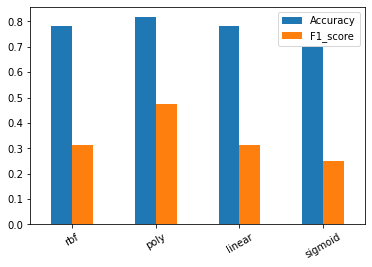

In [27]:
values = [0.783,0.816,0.783,0.7]
val=[0.315,0.476,0.315,0.25]
mydata = pd.DataFrame({"Accuracy":values,"F1_score":val})
mydata.index = ['rbf','poly','linear','sigmoid']
from pandas import plotting
mydata.plot(kind="bar",rot=30) 
plt.show()

We can't see a big difference between the different kernels but we have to choose the one that gives us the greatest accuracy and F1_score. This is the polynomial kernel 

In [28]:
ModelSVM = svm.SVC(kernel='poly')
ModelSVM.fit(X_train, Y_train)
PredSVM=ModelSVM.predict(X_test)

In [29]:
Accuracy=accuracy_score(Y_test, PredSVM)
F1_score=f1_score(y_true=Y_test, y_pred=PredSVM)
print(F1_score)
print(Accuracy)

0.47619047619047616
0.8166666666666667


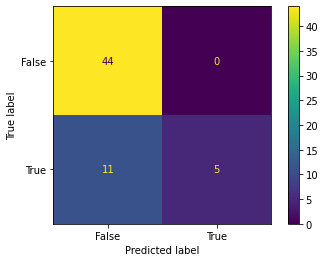

In [30]:
confusion_matrix = metrics.confusion_matrix(Y_test,PredSVM )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

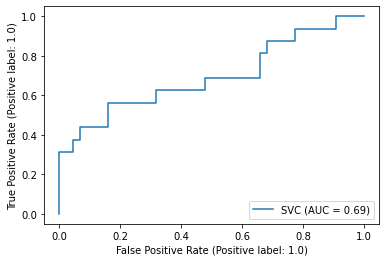

In [31]:
metrics.plot_roc_curve(ModelSVM, X_test, Y_test) 
plt.show()

### 4.2 Decision Tree 

The decision tree is a supervised machine learning algorithm that uses a set of rules to make decisions, similar to the way humans make decisions. In effect, Decision Tree Learning uses a divide-and-conquer strategy by performing a gluttonous search to identify optimal split points within a tree. This splitting process is then repeated in a top-down, recursive manner until all, or the majority, of records have been classified under specific class labels. Whether or not all data points are classified as homogeneous sets depends mostly on the complexity of the decision tree. Smaller trees are more easily able to reach pure leaf nodes, i.e., data points in a single class. However, as a tree grows in size, it becomes increasingly difficult to maintain this purity, and the result is usually too little data falling within a given subtree. When this happens, it is called data fragmentation, and it can often result in overfitting.

the criterion for selecting variables and hierarchy in decision trees can be tricky. Indeed,
Variables are selected based on a complex statistical criterion that is applied to each decision node.
Now, the criterion for selecting variables in decision trees can be done via two approaches :
- **1. Entropy and information gain**
- **2. Gin Index**

Entropy is a measure of the disorder or impurity in a node. The Gini or impurity index measures
the probability that a random instance will be misclassified when chosen at random.
In our case, we have chosen to work with entropy and a maximum tree depth of three levels, in
order to avoid over-fitting.

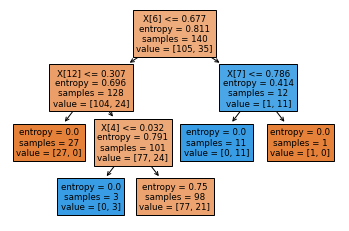

In [37]:
ModelTree=DecisionTreeClassifier(criterion = "entropy",max_depth=3)
ModelTree.fit(X_train,Y_train)
PredTree=ModelTree.predict(X_test)
plot_tree(ModelTree,filled=True)
plt.show()

In [38]:
Accuracy=accuracy_score(Y_test, PredTree)
F1_score=f1_score(y_true=Y_test, y_pred=PredTree)
print(F1_score)
print(Accuracy)

0.09523809523809523
0.6833333333333333


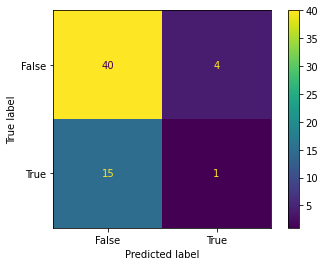

In [39]:
confusion_matrix = metrics.confusion_matrix(Y_test, PredTree)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

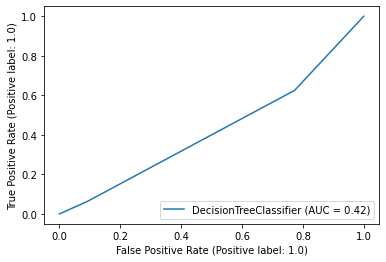

In [40]:
metrics.plot_roc_curve(ModelTree, X_test, Y_test) 
plt.show()

### 4.3 Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [41]:
ModelLogr=LogisticRegression()
ModelLogr.fit(X_train,Y_train)
PredLogr=ModelLogr.predict(X_test)

In [42]:
Accuracy=accuracy_score(Y_test, PredLogr)
F1_score=f1_score(y_true=Y_test, y_pred=PredLogr)
print(F1_score)
print(Accuracy)

0.3
0.7666666666666667


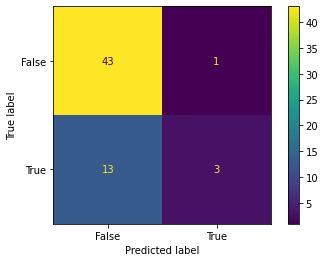

In [43]:
confusion_matrix = metrics.confusion_matrix(Y_test, PredLogr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

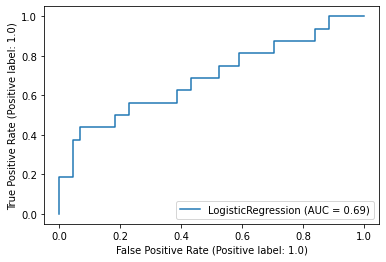

In [44]:
metrics.plot_roc_curve(ModelLogr, X_test, Y_test) 
plt.show()

### 4.4 Random Forest 

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [47]:
ModelRanF=RandomForestClassifier(n_estimators=100,criterion='gini')
ModelRanF.fit(X_train,Y_train)
PredRanF=ModelRanF.predict(X_test)

In [48]:
Accuracy=accuracy_score(Y_test, PredRanF)
F1_score=f1_score(y_true=Y_test, y_pred=PredRanF)
print(F1_score)
print(Accuracy)

0.5
0.8


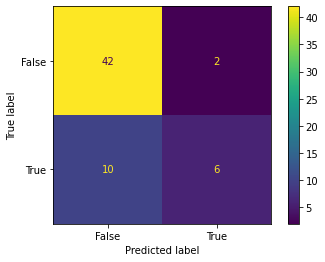

In [49]:
confusion_matrix = metrics.confusion_matrix(Y_test, PredRanF)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

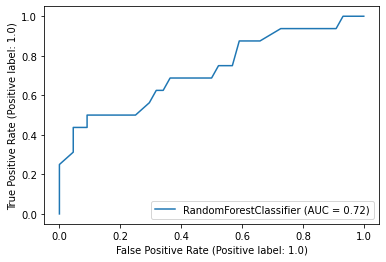

In [50]:
metrics.plot_roc_curve(ModelRanF, X_test, Y_test) 
plt.show()

### 4.5 K-nearest neighbors (KNN) 

KNN is a simple supervised machine learning (ML) algorithm that can be used for classification or regression tasks - and is also frequently used in missing value imputation. It is based on the idea that the observations closest to a given data point are the most "similar" observations in a data set, and thus we can classify unexpected points based on the values of the closest existing points. By choosing K, the user can select the number of nearest observations to use in the algorithm. We are also interested in a way to choose the K for which the classification will be best. There are two ways to find it: the first is to plot the K-value and the corresponding error rate for the data set, while the second is to plot the K-value and the corresponding accuracy rate for the data set. 

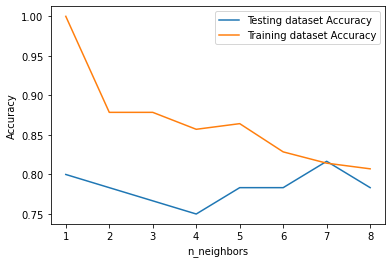

In [35]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
  
# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
      
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, Y_train)
    test_accuracy[i] = knn.score(X_test, Y_test)
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

We see that the accuracy of the test data takes its highest value when k=7 

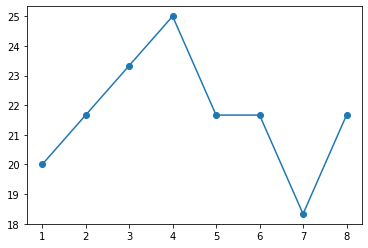

In [36]:
errors = []
for k in range(1,9):
    knn = KNeighborsClassifier(n_neighbors=k)
    errors.append(100*(1 - knn.fit(X_train, Y_train).score(X_test, Y_test)))
plt.plot(range(1,9), errors, 'o-')
plt.show()

we can see that the best prediction rate is obtained for a K equal to 7. Above this value, we can observe the phenomenon called overfitting which occurs when the training data used to build a model explains the data very well or even "too well" but fails to make useful predictions for new data.

**In both cases the best value of k is equal to 7** 

In [51]:
Modelknn = KNeighborsClassifier(n_neighbors = 7)
Modelknn.fit(X_train,Y_train)
PredKnn=Modelknn.predict(X_test)

In [52]:
Accuracy=accuracy_score(Y_test,PredKnn)
F1_score=f1_score(y_true=Y_test, y_pred=PredKnn)
print(F1_score)
print(Accuracy)

0.56
0.8166666666666667


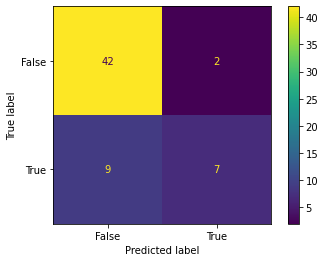

In [53]:
confusion_matrix = metrics.confusion_matrix(Y_test, PredKnn)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

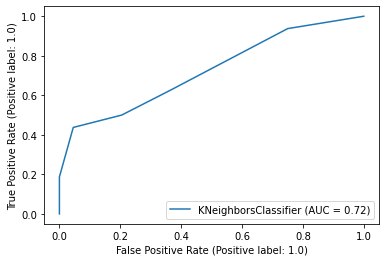

In [54]:
metrics.plot_roc_curve(Modelknn, X_test, Y_test) 
plt.show()

### 4.6 Recurrent Neural Networks (RNN)

Neural networks, also known as artificial neural networks or simulated neural networks, are
a subset of machine learning and are at the heart of deep learning algorithms. Their name and
structure are inspired by the human brain, mimicking the way that biological neurons signal to one
another.

Artificial neural networks are comprised of a node layers, containing an input layer, one or more
hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has
an associated weight and threshold. If the output of any individual node is above the specified
threshold value, that node is activated, sending data to the next layer of the network. Otherwise,
no data is passed along to the next layer of the network.

A **recurrent neural network**  is a class of artificial neural networks where connections between nodes can create a cycle, allowing output from some nodes to affect subsequent input to the same nodes. This allows it to exhibit temporal dynamic behavior.

We set up a neural network that contains 6 layers, the first 5 layers contain 5 neurons and the last layer contains 2 neurons since our problem is to classify the data according to 2 classes. We use two activation functions:
- **Relu**: This function allows us to perform a filter on our data. It lets positive values (x > 0) pass through the following layers of the neural network
- **Sigmoid**: The Sigmoid function gives a value between 0 and 1, a probability. It is therefore very useful for binary classification, when a model must determine only two labels
 $$ fonction\_Sigmoid(x)= \frac{1}{1+exp(-x)}$$
 
We also use the **ADAM** optimization function which is an extension of the stochastic gradient descent. In this function, the current averages of the gradients and the second moments of the gradients are used.


In [21]:
y_train=to_categorical(Y_train)
y_test=to_categorical(Y_test)
model=Sequential()
n_cols=X.shape[1]
model.add(Dense(5,activation="relu",input_shape=(n_cols,)))
model.add(Dense(5,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(5,activation="relu"))
model.add(Dense(2,activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
model.fit(X_train,y_train,epochs=10)
predRNN=model.predict(X_test)

Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.4571
Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.7500
Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.7500
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.7500
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.7500
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6863 - accuracy: 0.7500
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.7500
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.7500
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.7500
Epoch 10/10
2/2 [==============================] - 0s 2ms/step


In [22]:
Accurracy=model.evaluate(X_test,y_test,verbose=0)
print("Accuracy on test:{} \n Error on test:{}".format(Accurracy[1],1-Accurracy[1]))

Accuracy on test:0.7333333492279053 
 Error on test:0.2666666507720947


### 4.7   Convolutional Neural Networks (CNN)

In machine learning, a convolutional neural network is a type of artificial neural network in which the connection pattern between neurons is inspired by the visual cortex of animals. The neurons in this region of the brain are arranged to correspond to overlapping regions in the paving of the visual field. Their functioning is inspired by biological processes, consisting of a multilayer stack of perceptrons, whose purpose is to preprocess small amounts of information.

A convolutional neural network is mainly based on the convolution product which consists in applying a filter on an image.
The filter is a small square matrix of variable size (3x3, 5x5, 9x9, ...) called kernel or convolution kernel. We apply a kernel on each portion of the image, and combine the values of these pixels weighted by the matrix in order to obtain a reduced size information. This operation is in fact a simple scalar product between the matrix of the selected pixels and the kernel matrix.

In classifier CNNs, the network takes an image as input and applies a number of kernels or convolution kernels to it.
Each one produces a convolution map that highlights a particular feature of the image and so on for the following layers, with a process of increasing the complexity of the interpreted features. However it is possible and even strongly recommended in a convolution network to add an intermediate operation called Pooling, allowing to reduce the amount of information while maintaining its meaning.

Since the CNN takes images as input, we will have to reload the original images as a tensor with the following lines of code:


In [25]:
folder = './Original Images/'
photos, labels = list(), Y
for file in os.listdir(folder):
    photo = image.load_img(folder + file, target_size=(200, 200))
    # convert to numpy array
    photo = image.img_to_array(photo)
    photos.append(photo)

# convert to a numpy arrays
photos = np.asarray(photos)

We divide the image base into training and test 

In [26]:
train_images, test_images, train_labels, test_labels = train_test_split(photos, labels, test_size = 0.3)
len(train_images)

140

We create our model of CNN:  
- The first step is to normalize the database
- Then we set up 4 convolution layers using the **con2D** function, these layers take as parameters several variables like **stride** and **padding**:

     -- **Stride**:  the stride is a parameter that denotes the number of pixels through which the window moves after each operation
     
     -- **Padding**: Padding, it refers to the amount of pixels added to an image when it is being processed by the kernel of a CNN. For example, if the padding in a CNN is set to zero, then every pixel value that is added will be of value zero. If, however, the zero padding is set to one, there will be a one pixel border added to the image with a pixel value of zero.

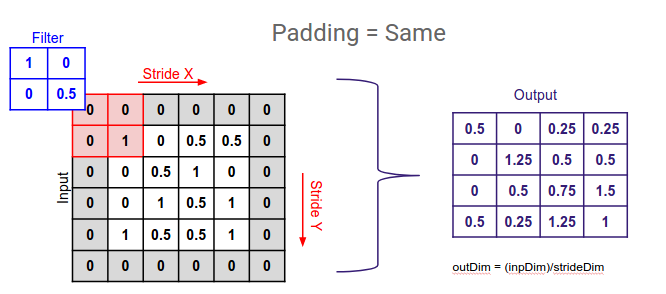

- We also create a **Dropout layer** which is a mask that cancels the contribution of some neurons to the next layer and leaves all others unchanged

- we then use the **Pooling layers** which are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network. In our case, we choose the max pooling that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.

- we use also a **Batch Normalization**, which normalizes the inputs heading into the next layer, ensuring that the network always creates activations with the same distribution that we desire

- After the step of feature extraction by convolution layers, we will flatten the data. Then, we will create 3 densely connected layers. In each of these layers we decrease the number of neurons in order to get closer to the mem number of neurons for our two classes. The kernel constraint can regularize the data as it learns, which also prevents overfitting. This is why we will use maxnorm

- In the last layer, we use this time the softmax activation function unlike the RNN where we used Sigmoid. The softmax function starts from a vector $(x_0,x_1,\cdots)$ with any coefficients, and returns a vector with positive coefficients of sum 1.

$ \mathrm{softmax} (x_0,x_1,\cdots) = (y_0,y_1,\cdots)$, où les y_i valent :
$$ y_{i}=\frac{exp(x_{i})}{\sum_{p>0} exp(x_{p})}$$
  

In [27]:
n_classes = 2
train_labels = to_categorical(train_labels, n_classes)
test_labels = to_categorical(test_labels, n_classes)
model = Sequential()
# 1 Layer
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1),
                 activation='relu', padding='same', 
                 input_shape=(200, 200, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
#2 layer
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#3 layer
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#4 layer
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1,1),
                 activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#Flattening
model.add(Flatten())
model.add(Dropout(0.2))

#1 layer 
model.add(Dense(256, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#2 Layer
model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#3 Layer
model.add(Dense(2, activation='softmax'))


In [28]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels))

Epoch 1/20
5/5 [==============================] - 27s 5s/step - loss: 0.8244 - accuracy: 0.5857 - val_loss: 1.2393 - val_accuracy: 0.2333
Epoch 2/20
5/5 [==============================] - 22s 4s/step - loss: 0.5987 - accuracy: 0.7714 - val_loss: 0.6239 - val_accuracy: 0.7667
Epoch 3/20
5/5 [==============================] - 22s 4s/step - loss: 0.5291 - accuracy: 0.7714 - val_loss: 0.5544 - val_accuracy: 0.7667
Epoch 4/20
5/5 [==============================] - 22s 4s/step - loss: 0.5250 - accuracy: 0.8214 - val_loss: 0.5451 - val_accuracy: 0.7667
Epoch 5/20
5/5 [==============================] - 22s 4s/step - loss: 0.4822 - accuracy: 0.8286 - val_loss: 0.5459 - val_accuracy: 0.7667
Epoch 6/20
5/5 [==============================] - 23s 5s/step - loss: 0.4170 - accuracy: 0.8714 - val_loss: 0.5503 - val_accuracy: 0.7667
Epoch 7/20
5/5 [==============================] - 26s 5s/step - loss: 0.4412 - accuracy: 0.8357 - val_loss: 0.5482 - val_accuracy: 0.7667
Epoch 8/20
5/5 [==================

In [29]:
# Probabilities
proba = model.predict(test_images)

#Labels
label = []
for i in proba:
    if i[0] > i[1]:
        label.append(0)
    else:
        label.append(1)
        
label = np.array(label)
label

2/2 [==============================] - 2s 732ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
Accurracy=model.evaluate(test_images,proba,verbose=0)
print("Accuracy on test:{} \n Error on test:{}".format(Accurracy[1],1-Accurracy[1]))

Accuracy on test:1.0 
 Error on test:0.0


### 4.8 Long short-term memory (LSTM) 

Long Short Term Memory Networks (LSTM) are an extension for recurrent neural networks, which extends their memory. Therefore, it is well suited for learning important experiences that have very long lags in between.

The units of an LSTM are used as building blocks for the layers of an RNN, which is then often called an LSTM network.

LSTMs allow RNNs to remember their inputs over a long period of time. This is because LSTMs hold their information in a memory, which is very similar to the memory of a computer because the LSTM can read, write and delete information from its memory.

This memory can be seen as a gated cell, where gated means that the cell decides to store or delete information, depending on the importance it attributes to the information. The assignment of importance is done through weights, which are also learned by the algorithm. This simply means that it learns over time which information is important and which is not.

In [73]:
train_images = color.rgb2gray(train_images)
test_images = color.rgb2gray(test_images)
train_images = np.reshape(train_images, (-1,train_images.shape[1],1))
test_images = np.reshape(test_images, (-1,test_images.shape[1],1))
train_images=train_images[:140]
test_images=test_images[:140]

In [74]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images /= 255
test_images /= 255
n_classes = 2
train_labels = to_categorical(train_labels, n_classes)
test_labels = to_categorical(test_labels, n_classes)

model = keras.models.Sequential()

#Adding the model layers
model.add(keras.layers.LSTM(128, batch_input_shape=(140,200,1), stateful=True,return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='softmax'))


#Compiling the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

#Fitting data to the model
history = model.fit(train_images, train_labels,epochs=10,batch_size=140)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (140, 200, 128)           66560     
                                                                 
 dropout_9 (Dropout)         (140, 200, 128)           0         
                                                                 
 lstm_3 (LSTM)               (140, 128)                131584    
                                                                 
 dense_12 (Dense)            (140, 64)                 8256      
                                                                 
 dropout_10 (Dropout)        (140, 64)                 0         
                                                                 
 dense_13 (Dense)            (140, 2)                  130       
                                                                 
Total params: 206,530
Trainable params: 206,530
Non-tr

In [75]:
testPredict = model.predict(test_images,batch_size=140)
test_loss, test_acc=model.evaluate(test_images,testPredict,verbose=0,batch_size=140)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1/1 [==============================] - 1s 921ms/step
Test Loss: 0.6341595649719238
Test Accuracy: 1.0


## Comparaison  

We compare the performance of the different classification models we tested previously 

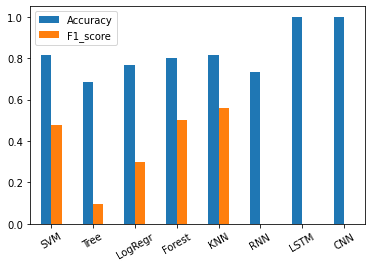

In [76]:
values = [0.8166666666666667,0.6833333333333333,0.7666666666666667,0.8,0.8166666666666667,0.7333333492279053,1,1]
val=[0.47619047619047616,0.09523809523809523,0.3,0.5,0.56,0,0,0]
mydata = pd.DataFrame({"Accuracy":values,"F1_score":val})
mydata.index = ['SVM', 'Tree', 'LogRegr','Forest','KNN','RNN','LSTM','CNN']
mydata.plot(kind="bar",rot=30) 
plt.show()

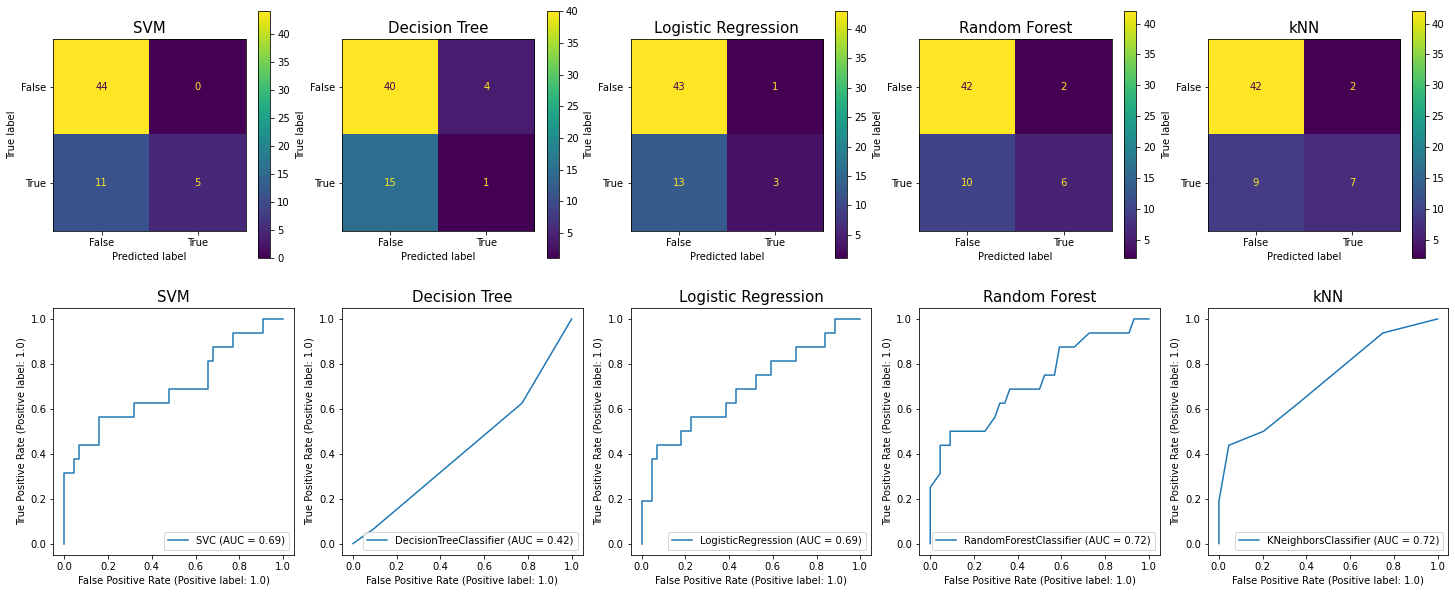

In [77]:
fig, axs = plt.subplots(2, 5, figsize = (25, 10))
Pred=[PredSVM,PredTree,PredLogr,PredRanF,PredKnn]
names= [ "SVM", "Decision Tree","Logistic Regression", "Random Forest", "kNN"]

for i, pred in enumerate(Pred):
    confusion_matrix = metrics.confusion_matrix(Y_test,pred )
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(ax = axs[0,i])
    axs[0,i].set_title(names[i], fontsize = 15)
    
Model=[ModelSVM,ModelTree,ModelLogr,ModelRanF,Modelknn]
for i, model in enumerate(Model):
    metrics.plot_roc_curve(model, X_test, Y_test,ax=axs[1,i]) 
    axs[1,i].set_title(names[i], fontsize = 15)

We notice that all neural networks have a very high performance especially the **CNN** and the **LSTM** which gives an accuracy of 100%. The **KNN** also performs very well, it gives an AUC of 72% with only 10 misclassified individuals. However, the **decision tree** does not perform really well at all in our case  

## Conclusion 

In the first project, we were able to extract features from binary images using the regionprops function. In this project, the study was done on RGB images, at the beginning we extracted the features manually with regionprops, and the Local Binary Patterns method. These methods are crucial to implement, but their complexity in terms of time and memory is quite significant, so we thought of selecting the features while being ecological by using score functions.  We were then able to implement a multitude of classification models such as neural networks, kNN, and decision trees on three-dimensional data.  

## References

I put the resources that helped me to process the different steps of this project. However, a large part of this project I did according to my own knowledge and what we did in the courses of the data science major 

https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

https://victorzhou.com/blog/keras-cnn-tutorial/

https://www.tensorflow.org/tutorials/images/cnn

https://openclassrooms.com/fr/courses/4011851-initiez-vous-au-machine-learning/4022441-entrainez-votre-premier-k-nn


https://www.kaggle.com/code/shivanisheth2911/lstm-keras-on-mnist

https://datasciencetoday.net/index.php/fr/machine-learning/148-reseaux-neuronaux-recurrents-et-lstm

